# Imports

In [9]:
from zipfile import ZipFile

from PIL import Image
import pytesseract
import cv2 as cv
import numpy as np

# loading the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')

small_file = 'readonly/small_img.zip'
big_file = 'readonly/images.zip'

# Functions

In [10]:
def find_keyword(zip_file, keyword):
    relevant_images = []
    
    with ZipFile(zip_file, 'r') as zf:
        filelist = zf.infolist()
        print(f"The Zipfile contains {len(filelist)} files.")
        
        for file in filelist:
            with zf.open(file) as current:
                with Image.open(current) as img_raw:
                    img = img_raw.convert('RGB')
                    if _contains_keyword(img, keyword):
                        print(f"{file.filename}: Contains the keyword!")
                        relevant_images.append((file.filename, img))
                    else:
                        print(f"{file.filename}: Is not relevant.")
    
    print("All files extracted.")
    return relevant_images

def _contains_keyword(image, keyword):
    text = _get_ocr_result(image)
    
    if keyword in text:
        return True
    else:
        return False

def _reduce_res(img, long_side_px: int):
    orig_w, orig_h = img.size
    aspect = orig_w / orig_h
    
    if aspect > 1:
        new_img = img.resize((long_side_px, round(long_side_px / aspect)), Image.BICUBIC)
    else:
        new_img = img.resize((round(long_side_px * aspect), long_side_px), Image.BICUBIC)
    
    return new_img

def _optimise_for_ocr(img):
    gray = img.convert('L')
    
    return gray

def _get_ocr_result(image):
    ocr_text = ''
    
    image = _reduce_res(image, 3600)
    image = _optimise_for_ocr(image)
    ocr_text = pytesseract.image_to_string(image)
    
    return ocr_text

def get_face_images(images):
    face_images = []
    
    for name, image in images:
        face_rectangles = _detect_people(image)
        
        if face_rectangles is None:
            face_images.append((name, None))
            print("No faces where recognised in this picture.")
        
        else:
            faces = _extract_faces(image, face_rectangles)
            face_images.append((name, faces))
            print(f"{name}: Recognised {len(faces)} faces.")
            
    return face_images

def _detect_people(image):
    rectangles = []
    
    # Convert to OpenCV and RGB to Grayscale
    gray = cv.cvtColor(np.array(image), cv.COLOR_RGB2GRAY)
    rectangles = face_cascade.detectMultiScale(gray, 1.3, 5)
    try:
        rectangles = rectangles.tolist()
    except AttributeError:
        rectangles = None
    
    return rectangles

def _extract_faces(image, rectangles):
    faces = []
    
    for rect in rectangles:
        left = rect[0]
        upper = rect[1]
        right = left + rect[2]
        lower = upper + rect[3]
        face = image.crop((left, upper, right, lower))
        face.thumbnail((100, 100), Image.BICUBIC)
        faces.append(face)
        
    return faces

def _create_contact_sheet(faces):
    first_image = faces[0]
    size = 100
    x = 0
    y = 0
    columns = 5
    rows = -(-len(faces) // columns)  # Special trick to round UP
    
    # create an empty canvas
    contact_sheet = Image.new(first_image.mode, 
                              (size * columns, size * rows),
                              (12, 12, 30))  # background colour
    
    # fill the canvas with the images
    for num, img in enumerate(faces):
        # first paste the image
        contact_sheet.paste(img, (x, y))
    
        if x + size >= contact_sheet.width:
            x = 0
            y = y + size
        else:
            x = x + size
    
    return contact_sheet

def present_result(annotation, faces):
    print(f"\nResults found in file {annotation}")
    if faces is None:
        print("But there are not faces in that file.")
    else:
        sheet = _create_contact_sheet(faces)
        display(sheet)
        

# Program
## Keywords and Files

In [11]:
keyword_s = 'Christopher'
imgs_of_interest_s = find_keyword(small_file, keyword_s)

The Zipfile contains 4 files.
a-0.png: Contains the keyword!
a-1.png: Is not relevant.
a-2.png: Is not relevant.
a-3.png: Contains the keyword!
All files extracted.


In [3]:
keyword = 'Mark'
imgs_of_interest = find_keyword(big_file, keyword)

The Zipfile contains 14 files.
a-0.png: Contains the keyword!
a-1.png: Contains the keyword!
a-10.png: Contains the keyword!
a-11.png: Is not relevant.
a-12.png: Is not relevant.
a-13.png: Contains the keyword!
a-2.png: Contains the keyword!
a-3.png: Contains the keyword!
a-4.png: Is not relevant.
a-5.png: Is not relevant.
a-6.png: Is not relevant.
a-7.png: Is not relevant.
a-8.png: Contains the keyword!
a-9.png: Is not relevant.
All files extracted.


## Face Recognition

In [12]:
faces_s = get_face_images(imgs_of_interest_s)

faces_l = get_face_images(imgs_of_interest)

a-0.png: Recognised 6 faces.
a-3.png: Recognised 2 faces.
a-0.png: Recognised 6 faces.
a-1.png: Recognised 5 faces.
No faces where recognised in this picture.
a-13.png: Recognised 1 faces.
a-2.png: Recognised 2 faces.
a-3.png: Recognised 2 faces.
No faces where recognised in this picture.


## Final Result
### 'small_img.zip' searched for 'Christopher':


Results found in file a-0.png


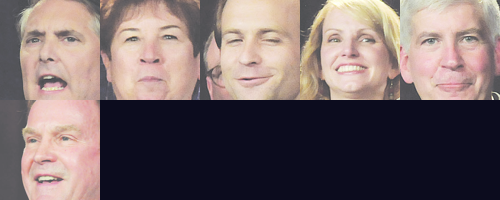


Results found in file a-3.png


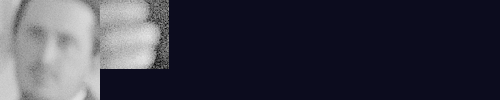

In [14]:
for name, group in faces_s:
    present_result(name, group)

### 'images.zip' searched for 'Mark':


Results found in file a-0.png


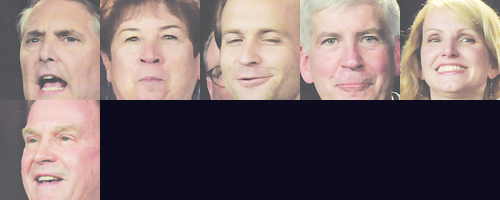


Results found in file a-1.png


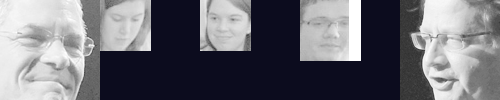


Results found in file a-10.png
But there are not faces in that file.

Results found in file a-13.png


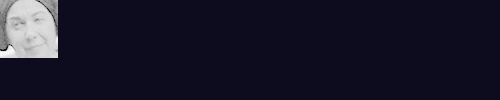


Results found in file a-2.png


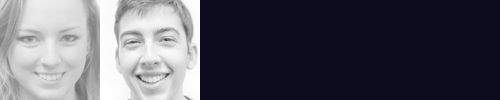


Results found in file a-3.png


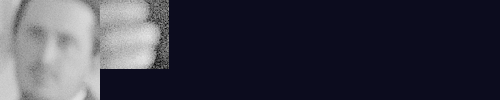


Results found in file a-8.png
But there are not faces in that file.


In [15]:
for name, group in faces_l:
    present_result(name, group)